In [1]:
from utility.data_loading import *
from sklearn.model_selection import train_test_split
from utility.data_preprocessing import *

training_data_name = "fd=0.3-0.7_hdf5"
testing_data = "califa_s_1.0"
x_dataset, y_dataset, metadata = load_hdf5_data(name=training_data_name, count=10)
x_test, y_test, metadata = load_hdf5_data(name=testing_data)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=1)

E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


(20, 100, 100)
(79, 100, 100)


In [2]:
"""

Add Gaussian noise to density map morphologies of galaxies generated by code supplied by Kenji Bekki
By James Caldon under supervision of Kenji Bekki (2021)

"""

import numpy as np
RANDOM_SEED_ = 2021
rng = np.random.default_rng(RANDOM_SEED_)

def add_gaussian_noise(np_arr):
    mean = 0
    sigmas = rng.uniform(0.02, 0.03, np_arr.shape[0])

    for i in range(np_arr.shape[0]):
        np_arr[i] = rng.normal(mean, sigmas[i], np_arr[i].shape) + np_arr[i] 

def add_point_sources(np_arr):
    import sys
    all_coords = tuple(np.hstack([np.vstack((np.full(randx, i), rng.choice(np_arr[i].shape[0], randx, replace=False), rng.choice(np_arr[i].shape[1], randx, replace=False))) for (i, randx) in zip(range(np_arr.shape[0]), rng.integers(0, 6, np_arr.shape[0]))]))
    print(sys.getsizeof(all_coords))
    np_arr[all_coords] = np.clip(np_arr[all_coords] + 0.5, 0, 1)

def add_background_galaxies(np_arr):
    from scipy import signal
    for i in range(np_arr.shape[0]):
        number_of_points = rng.integers(0, 10, 1)[0]
        rand_sizes = rng.integers(1, 4, number_of_points) * 2 + 1
        for rand_size in rand_sizes:
            gauss = np.outer(signal.windows.gaussian(rand_size, rand_size/6), signal.windows.gaussian(rand_size, rand_size/6)) * ((rng.random() / 2) + 0.25)
            rand_x = rng.integers(0, np_arr[i].shape[0] - rand_size, number_of_points)[0]
            rand_y = rng.integers(0, np_arr[i].shape[1] - rand_size, number_of_points)[0]
            slice_x = slice(rand_x, rand_x + rand_size)
            slice_y = slice(rand_y, rand_y + rand_size)
            np_arr[i, slice_x, slice_y]= np.clip(np_arr[i, slice_x, slice_y] + gauss, 0.0, 1.0)




def apply_gaussian_PSF(np_arr, sigma):
    from scipy.ndimage.filters import gaussian_filter
    for i in range(np_arr.shape[0]):
        gaussian_filter(np_arr[i, :, :], sigma, output=np_arr[i, :, :])

def apply_moffat_PSF(np_arr, gamma, alpha):
    from astropy.convolution import Moffat2DKernel, convolve
    for i in range(np_arr.shape[0]):
        kern = Moffat2DKernel(gamma, alpha)
        np_arr[i, :, :] = convolve(np_arr[i, :, :], kern)

def apply_airy_PSF(np_arr, radius):
    from astropy.convolution import AiryDisk2DKernel, convolve
    for i in range(np_arr.shape[0]):
        kern = AiryDisk2DKernel(radius)
        np_arr[i, :, :] = convolve(np_arr[i, :, :], kern)

    

In [3]:
add_point_sources(x_dataset)
add_background_galaxies(x_dataset)
add_gaussian_noise(x_dataset)
#apply_gaussian_PSF(x_dataset, 0.218598726) # General Gaussian PSF 0.218598726 0.573292215 1.3 20.84 8.85 ## 0.5148
#apply_moffat_PSF(x_dataset, 0.65049197562297747917932881055243, 1.3)
#apply_airy_PSF(x_dataset, 2)


x_dataset = np.expand_dims(x_dataset, axis=3)
y_dataset = np.expand_dims(y_dataset, axis=1)
x_train, x_val, y_train, y_val = train_test_split(x_dataset, y_dataset, shuffle=True, train_size=0.8, random_state=2021)


64


In [4]:
def create_datagen(subset):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        zoom_range=[0.5, 1.5],
        rotation_range=359,
        fill_mode='constant',
        cval = 0
        #validation_split = 0.2
    )
    datagen.fit(subset)
    return datagen

In [5]:
train_datagen = create_datagen(x_train)
val_datagen = create_datagen(x_val)
import matplotlib as mpl
from matplotlib import pyplot
%matplotlib inline
mpl.rcParams['figure.figsize'] = [10, 10]
mpl.rcParams['figure.dpi'] = 144
def visualize():

    # prepare iterator
    it = train_datagen.flow(x_train, batch_size=1, seed=2021)
    for i in range(1):
        # define subplot
        pyplot.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0]
        # plot raw pixel data
        pyplot.imshow(image)
    # show the figure
    pyplot.show()

In [6]:
it = train_datagen.flow(x_train, batch_size=1, seed=2021)



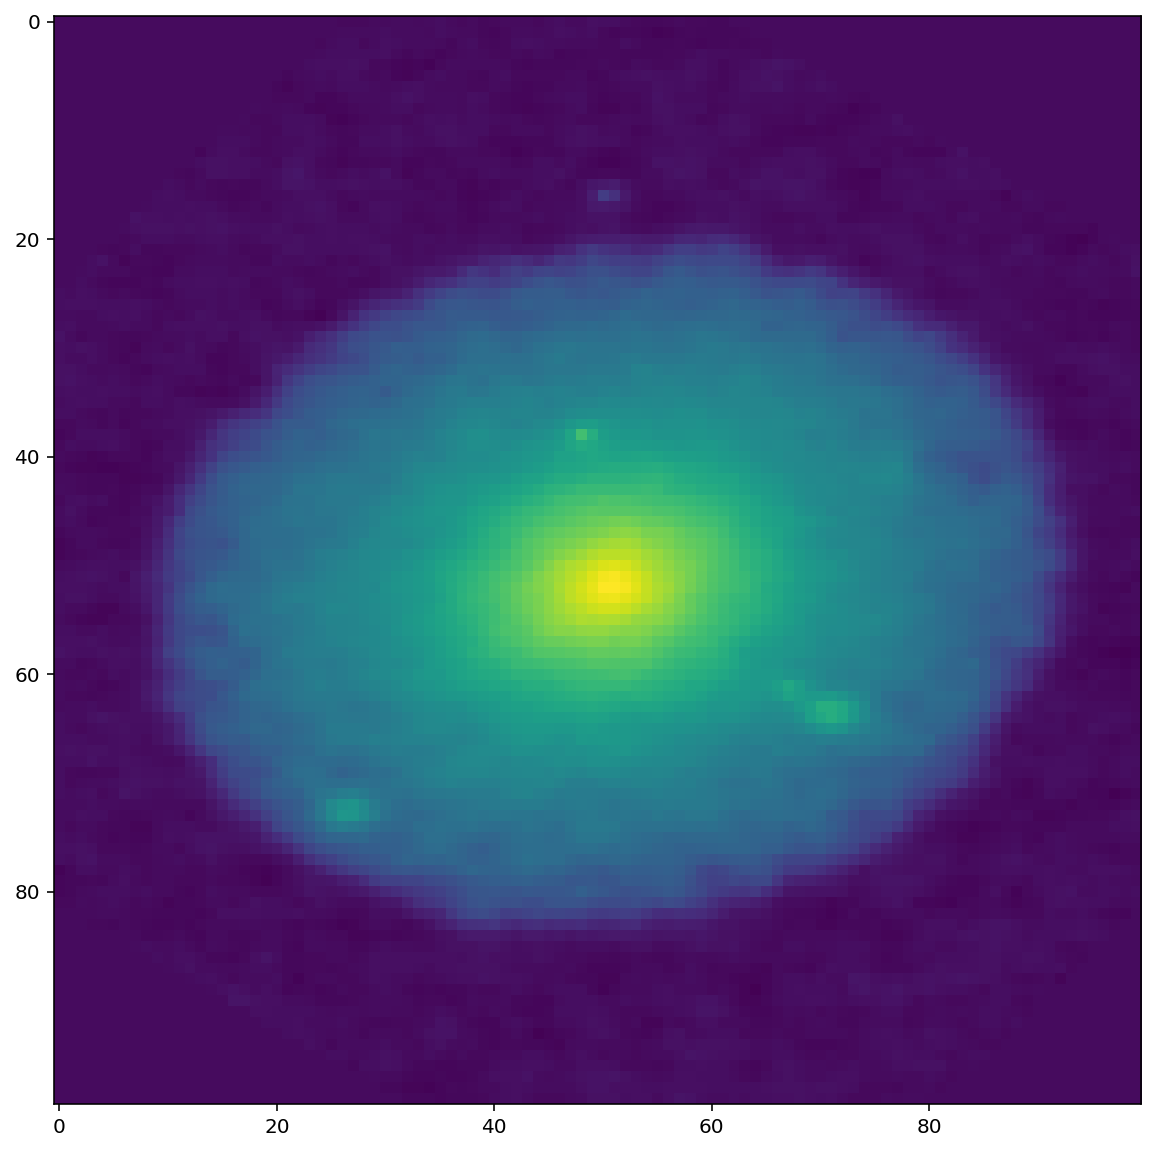

In [7]:
img = it.next()[0]
pyplot.imshow(img)

[]

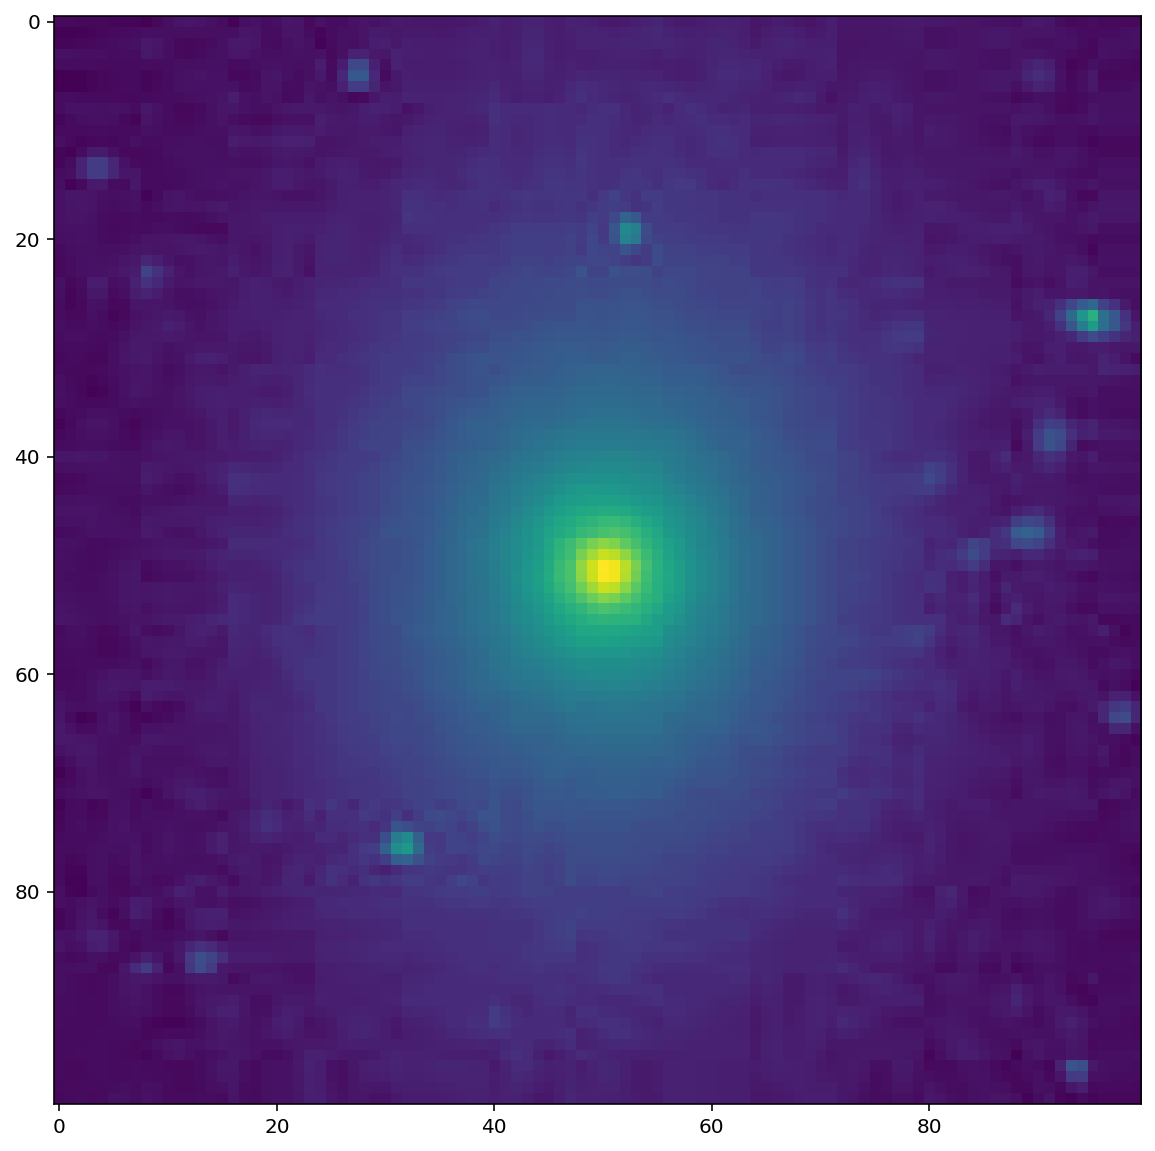

In [8]:
pyplot.imshow(x_test[0])
pyplot.plot()

In [10]:
np.max(img)

0.9699771